In [1]:
import os
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [52]:
content_path = './그린유령.jpg'
style_path = './숲속.jpg'

content_path = './해돋이.jpg'
style_path = './석양.jpg'

content_path = './석양.jpg'
style_path = './해돋이.jpg'

content_path = './커피.jpg'
style_path = './고흐1.jpg'


In [50]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

196608/195196 [==============================] - 0s 0us/step


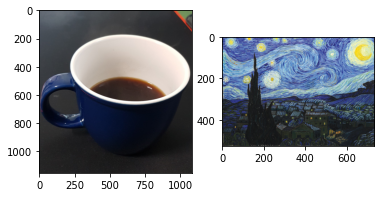

In [53]:
plt.subplot(1,2,1)
plt.imshow(plt.imread(content_path))
plt.subplot(1,2,2)
plt.imshow(plt.imread(style_path))

In [74]:
class gv():
  MAX_IMG_SIZE = 512

  content_layers = ['block5_conv4'] 
  style_layers = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1']
  # content_layers = ['block5_conv2'] 
  # style_layers = ['block1_conv1',
  #                 'block2_conv1',
  #                 'block3_conv1', 
  #                 'block4_conv1', 
  #                 'block5_conv1']

  style_weight=1e-2
  content_weight=1e4
  total_variation_weight=30

  epochs = 10
  steps_per_epoch = 100

  opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1 )

In [72]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_path, content_path): # Two layer_name_list
    super(StyleContentModel, self).__init__()
    self.__vgg =  self.__vgg_layers(gv.style_layers + gv.content_layers) # Model(~, ~)
    self.__style_image = self.__load_img(style_path)
    self.__content_image = self.__load_img(content_path)
    self.__image = tf.Variable(self.__content_image)
    self.__style_targets = self.__setting(self.__style_image)['style']
    self.__content_targets = self.__setting(self.__content_image)['content']

  def __vgg_layers(self, layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs) # broadcasting ??
    return model

  def __load_img(self, path_to_img):
    max_dim = gv.MAX_IMG_SIZE
    img = tf.io.read_file(path_to_img) # bytes
    img = tf.image.decode_image(img, channels=3) # shape(~,~,3) # uint8
    img = tf.image.convert_image_dtype(img, tf.float32) # from 0~255 to 0~1 

    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # (height, width)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32) # new (height, width)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] # (1, ~, ~, 3)
    return img

  def __tensor_to_image(self, tensor):
    tensor = tensor*255 # from 0~1 to 0~255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
      assert tensor.shape[0] == 1
      tensor = tensor[0]
    return PIL.Image.fromarray(tensor) # image, not array

  def __gram_matrix(self, input_tensor): # (1, height, width, ch)
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) # (1, height*width, ch) X (1, ch, height*width) # (1, ch, ch)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # height*width
    return result / (num_locations)

  
  def __style_content_loss(self): # maybe extractor(initial_image))
    outputs = self.__setting(self.__image) # always other image # Variable
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - self.__style_targets[name])**2) # outputs approaches target.
                            for name in gv.style_layers])
    style_loss *= gv.style_weight / len(gv.style_layers)
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - self.__content_targets[name])**2) 
                              for name in gv.content_layers])
    content_loss *= gv.content_weight / len(gv.content_layers)
    loss = style_loss + content_loss
    return loss

  def __setting(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # input_Tensor, didn't assign in Tensor..?
    outputs = self.__vgg(preprocessed_input) # y in 'y=f(x)', 'f' is Model
    style_outputs, content_outputs = (outputs[:len(gv.style_layers)], 
                                      outputs[len(gv.style_layers):])
    style_outputs = [self.__gram_matrix(style_output)
                     for style_output in style_outputs] # (5, 1, ch, ch)?
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(gv.content_layers, content_outputs)}
    style_dict = {style_name:value
                  for style_name, value
                  in zip(gv.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict} # {c: {}, s: {}} # target

  @tf.function()
  def __train_step(self):
    with tf.GradientTape() as tape:
      loss = self.__style_content_loss()
      # loss += gv.total_variation_weight * tf.image.total_variation(self.__image) # in or out

    grad = tape.gradient(loss, self.__image)
    gv.opt.apply_gradients([(grad, self.__image)])
    self.__image.assign(tf.clip_by_value(self.__image, 0.0, 1.0))

  
  def run(self, epochs=gv.epochs):
    start = time.time()
    step = 0
    for n in range(epochs):
      for m in range(gv.steps_per_epoch):
        step += 1
        self.__train_step()
        print(".", end='')
      display.clear_output(wait=True)
      display.display(self.__tensor_to_image(self.__image))
      print("Train step: {}".format(step))
    end = time.time()
    print("Total time: {:.1f}".format(end-start))

  def download(self):
    file_name = 'stylized-image.png'
    self.__tensor_to_image(self.__image).save(file_name)
    try:
      from google.colab import files
    except ImportError:
      pass
    else:
      files.download(file_name)

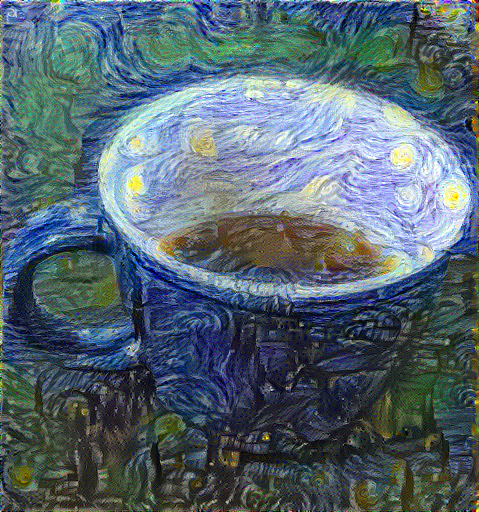

Train step: 1000
Total time: 102.8


In [75]:
mymodel = StyleContentModel(style_path, content_path)
mymodel.run()

In [76]:
mymodel.download()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_18
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
